In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# Question 1: Propensity Score Matching

In [39]:
data = pd.read_csv('Homework4-data/lalonde.csv', dtype={
    'treat': np.bool_,
    'age': np.uint8,
    'age': np.uint8,
    'nodegree': np.bool_,
    'married': np.bool_,
    'black': np.bool_,
    'hispan': np.bool_,
    're74': np.float32,
    're75': np.float32,
    're78': np.float32
})

In [40]:
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886


## 1 - A naive analysis

In [41]:
treated = data.re78[data.treat == True]

In [42]:
treated.describe()

count      185.000000
mean      6349.145508
std       7867.402344
min          0.000000
25%        485.229797
50%       4232.309082
75%       9642.999023
max      60307.929688
Name: re78, dtype: float64

In [43]:
not_treated = data.re78[data.treat == False]

In [44]:
not_treated.describe()

count      429.000000
mean      6984.169434
std       7294.164551
min          0.000000
25%        220.181305
50%       4975.504883
75%      11688.820312
max      25564.669922
Name: re78, dtype: float64

In [45]:
len(range(5))

5

In [46]:
def empirical_distribution(data):
    """Computes the empirical distribution of the provided pandas series"""
    return data.value_counts().sort_index().cumsum() / len(data)

We display the earnings in 1978 using boxplots. Remark that to compare and draw conclusions, it is important to use the same scale for the two data series (`sharey='row'` and `sharex='row'`)

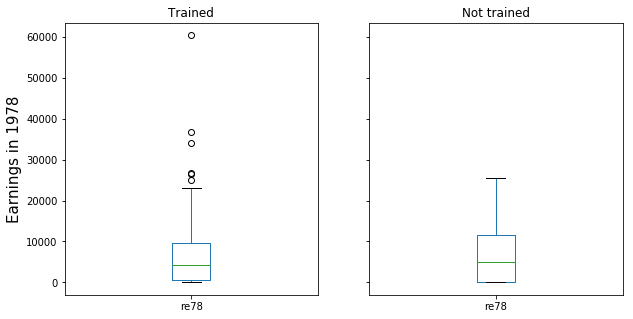

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               sharey='row', sharex='row',
                               figsize=(10, 5))

treated.plot.box(ax=ax1)
not_treated.plot.box(ax=ax2)
ax1.set_title('Trained')
ax2.set_title('Not trained')
ax1.set_ylabel('Earnings in 1978').set_size(15)

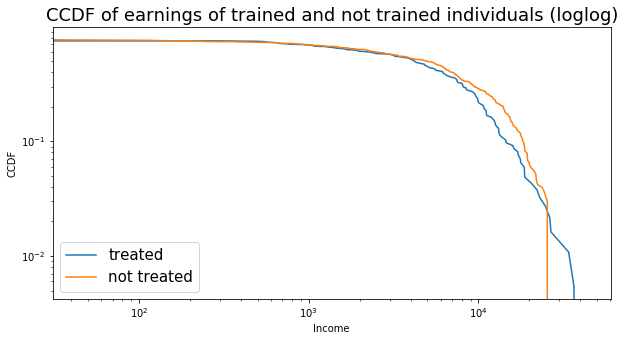

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
(1 - empirical_distribution(treated)).plot(ax=ax, logx=True, logy=True)
(1 - empirical_distribution(not_treated)).plot(ax=ax)
ax.legend(['treated', 'not treated'], fontsize=15)
ax.set_xlabel('Income')
ax.set_ylabel('CCDF')
ax.set_title('CCDF of earnings of trained and not trained individuals (loglog)').set_size(18)

A naive researcher may conclude that, except for some outliers, the training does not make a difference in determining the earnings of the cadidates

## 2 - A closer look at the data

For each feature, we compare its distribution in the control and in the treated group.

In [13]:
def get_feature(feature_name):
    """Returns the series corresponding to feature name.
    The returned element is a tuple of two elements, the first
    corresponding to the (treated, not_treated) group"""
    get_treated = lambda treated: data[feature_name][data.treat == treated]
    return get_treated(True), get_treated(False)

### Age

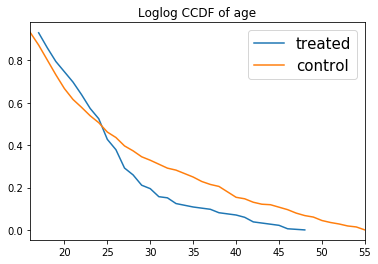

In [50]:
age_groups = get_feature('age')
for cdf in map(empirical_distribution, age_groups):
    (1 - cdf).plot()
plt.legend()
plt.legend(['treated', 'control'], fontsize=15)
plt.title('Loglog CCDF of age')
plt.show()

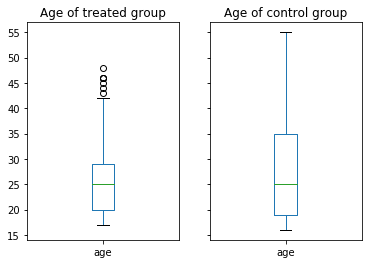

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row')
for ax, age_group in zip(axes, age_groups):
    age_group.plot.box(ax=ax)
axes[0].set_title('Age of treated group')
axes[1].set_title('Age of control group')
plt.show()

We can see that the members of the treated group are in general younger than the members of the control group.
The medians are very similar, but on the upper part of the distribution, the person in the treated group are younger than the one in the control group.
This leads to think that older people had a low chance to be treated and it might reduce bias in our control group if we removed them after a certain age.

### Education years

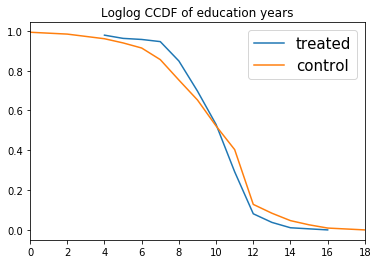

In [59]:
ed = get_feature('educ')
for cdf in map(empirical_distribution, ed):
    (1 - cdf).plot()
plt.legend(['treated', 'control'], fontsize=15)
plt.title('Loglog CCDF of education years')
plt.show()

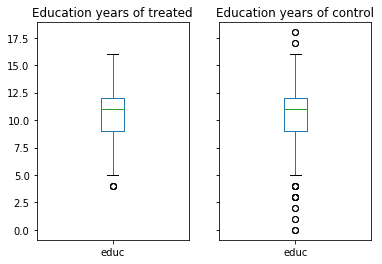

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row')
for ax, group in zip(axes, ed):
    group.plot.box(ax=ax)
axes[0].set_title('Education years of treated')
axes[1].set_title('Education years of control')
plt.show()

While the distributions of the variable in the two groups seem similar, the boxplot reveals an interesting detail: the control group has many outliers who studied for less than the 1/4 quantile. There's also some outliers in the maximum education years in the control group.

This might be caused by the fact that people who never studied or studied a lot tended to not get the treatment. Because of this, they might be poor subjects to add in our control group.

### Ethnicity

In [62]:
any(map(lambda tup: all(tup), data[data.hispan == data.black][['black', 'hispan']].values))

False

After having checked that there is no individual marked as both hispanic and black, we can plot the proportion of ethinicity in the the two populations:

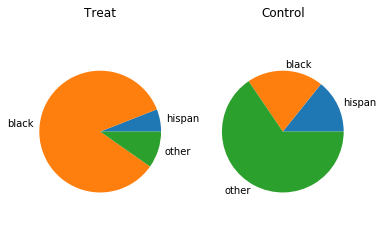

In [63]:
ethnicities = ['hispan', 'black']
fig, axes = plt.subplots(nrows=1, ncols=2)

for ax, treated in zip(axes, (True, False)):
    # Extract hispanic and black boolean indicators
    eths = data[data.treat == treated][ethnicities]
    # If neither black nor hispanic, add a True to indicate other category
    eths['other'] = reduce(lambda x, y: x & y, map(lambda e: ~eths[e], ethnicities)) # <3 mapreduce
    # Sum to obtain ethnic count
    eths = eths.sum(axis=0)
    # Plot
    ax.axis('equal')
    ax.set_title('Treat' if treated else 'Control')
    ax.pie(eths.values, labels=eths.index)

This reveals an interesting fact: the control and treated populations have very different compositions. While most of the control individuals are neither black nor hispanic (can we assume white?), most of the treated population is black.

### Civil status

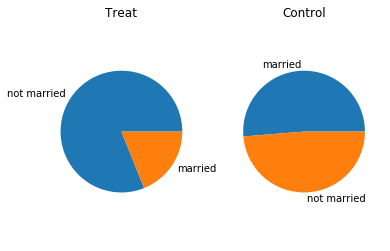

In [64]:
groups = get_feature('married')

fig, axes = plt.subplots(nrows=1, ncols=2)

for ax, g in zip(axes, groups):
    c = g.value_counts()
    ax.axis('equal')
    ax.pie(c.values, labels=['married' if t else 'not married' for t in c.index])

axes[0].set_title('Treat')
axes[1].set_title('Control')
plt.show()

These piecharts highlight another important difference in population composition: most of the treated individuals are not married while almost half of the control population is married.

### Degree

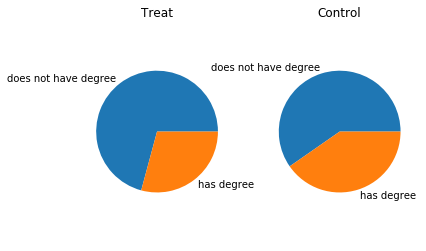

In [65]:
groups = get_feature('nodegree')

fig, axes = plt.subplots(nrows=1, ncols=2)

for ax, g in zip(axes, groups):
    c = g.value_counts()
    ax.axis('equal')
    ax.pie(c.values, labels=['does not have degree' if t else 'has degree' for t in c.index])

axes[0].set_title('Treat')
axes[1].set_title('Control')
plt.show()

Yet another important difference: slightly more treated individuals than controlled ones have a degree, which might directly influence their earnings

### Pre-treatment earnings

In [66]:
features = ['re74', 're75']

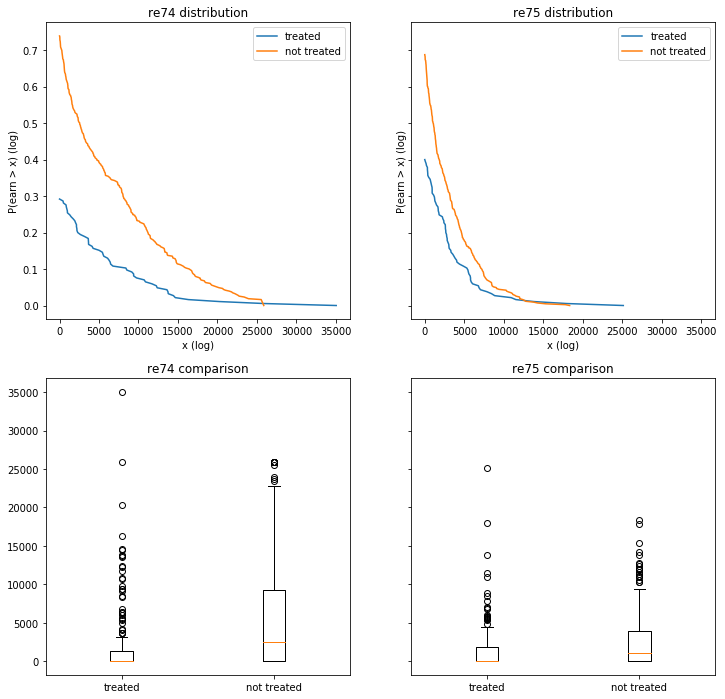

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='row', figsize=(12, 12))

for cell, year in zip(axes[0], features):
    for treated in (True, False):
        earnings = data[data.treat == treated][features]
        cell.plot(1 - empirical_distribution(earnings[year]))
        cell.set_xlabel('x (log)')
        cell.set_ylabel('P(earn > x) (log)')
    cell.legend(['treated', 'not treated'])
    cell.set_title(year + ' distribution')           
    
for cell, year in zip(axes[1], features):
    cell.boxplot([data[year][data.treat == treated].values for treated in (True, False)])
    cell.set_xticklabels(['treated', 'not treated'])
    cell.set_title(year + ' comparison')

We observe that the control population had higher earnings than the treated population before the the treatment.

In fact, most of the treated population had no income before the treatment, which might show a bias in treatment towards individuals with no income.

Also, the not treated population had a major reduction in their income distribution after only 1 year.
It implies that many people considered for the not treated population already had work experience prior to the test, but lost their job recently.
This might create a bias in the not treated population, because it is likely that someone with previous work experience has better odds of finding a job than someone with no work experience or long term previous unemployment.

## 3 - A propensity score model

In [69]:
data.dtypes

id           object
treat          bool
age           uint8
educ          int64
black          bool
hispan         bool
married        bool
nodegree       bool
re74        float32
re75        float32
re78        float32
dtype: object

In [25]:
boolean_features = ['treat', 'black', 'hispan', 'married', 'nodegree']

no_id = data.loc[:, data.columns != 'id']
no_id = no_id.loc[:, no_id.columns != 're78'].copy() # Based on pre-treatment features => exclude post treatment features

for feat in boolean_features:
    no_id.loc[:, feat] = no_id[feat].astype(np.uint8)

In [26]:
print('Features used for propensity score computation:')
[col for col in no_id.columns]

Features used for propensity score computation:


['treat',
 'age',
 'educ',
 'black',
 'hispan',
 'married',
 'nodegree',
 're74',
 're75']

In [27]:
x_train = no_id.loc[:, no_id.columns != 'treat'].as_matrix()
y_train = no_id.loc[:, 'treat'].as_matrix()

In [28]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predictions = lr.predict_proba(x_train)

In [29]:
predictions.shape, np.all(np.sum(predictions, axis=1))

((614, 2), True)

`predict_proba` returns a bidimensional array which has as many rows as data points and as many columns as classification classes. We are interested in the propensity score which is the probability of receiving the treatment. Therefore we want the second column of `predictions`

In [30]:
# Rebuild indexed series
propensities = pd.Series(predictions[:, 1], index=no_id.index)

## 4 - Balancing the dataset via matching